# IndustryClassificationTask
### At first let's import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import train_test_split
#from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# from nltk.corpus import stopwords
from joblib import dump,load
from imblearn.over_sampling import SMOTE

In [2]:
#Reading the data as dataframe
df = pd.read_csv('Job titles and industries.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [3]:
#checking how many unique titles we have, I'll check again after cleaning to see the effect
len(df['job title'].unique())

3890

In [4]:
#df.duplicated().sum()
#df.drop_duplicates(keep = 'last', inplace = True)

In [5]:
classes = df['industry'].unique()
df.groupby('industry')['industry'].count()

industry
Accountancy     374
Education      1435
IT             4746
Marketing      2031
Name: industry, dtype: int64

#### it seems that data is imbalanced
i'll work first on cleaning the data then handle the imbalance later

at first added the common words to remove, then i decided to remove 'manager' too becaude it was confusing the classifier! the data contains sales managers in IT, Marketing and education. with marketing the most. so i decided to remove the word.

In [6]:
def cleaning(df):
    #Removing leading and tailing spaces
    df['job_title_clean'] = df['job title'].str.strip()
    #After some investigation found that after '-' charater isn't important
    #So, I'll remove everything after '-'
    df['job_title_clean'] = df['job_title_clean'].str.split('-')
    df['job_title_clean'] = df['job_title_clean'].str[0]
    # Making sure that all of the letters are lower
    df["job_title_clean"] = df["job_title_clean"].str.lower()
    #Removing unuseful words
    words_to_remove = ['senior','junior','full','pre','mid','part','entry level','time','arabic','english'
                       ,'up','to','based',' and',' &',' in',' of','manager']
    for word in words_to_remove:
        df["job_title_clean"] = df["job_title_clean"].str.replace(word, '')
    #Keeping only words
    df['job_title_clean'] = df.apply(lambda row: re.sub(r"[^a-zA-Z ]","",row['job_title_clean']), axis=1)

# stop = stopwords.words('english')

### Splitting the data
#### First, train and test
will remove the dubplication from the train only and let the test as it

In [7]:
train_df1,test_df = train_test_split(df, test_size=0.5, random_state=42,stratify = df['industry'])
X_test = test_df.drop(columns='industry')
y_test = test_df['industry']
train_df1.drop_duplicates(keep = 'last', inplace = True)

<ipython-input-7-26f09bb99e78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1.drop_duplicates(keep = 'last', inplace = True)


#### Second, train and validation to use validation in model

In [8]:
train_df2, val_df = train_test_split(train_df1, test_size=0.2, random_state=42,stratify = train_df1['industry'])
X_train = train_df2.drop(columns='industry')
y_train = train_df2['industry']

X_val = val_df.drop(columns='industry')
y_val = val_df['industry']

### Cleaning the data

In [9]:
cleaning(X_train)
cleaning(X_val)
cleaning(X_test)

In [10]:
cleaning(df)
len(df['job_title_clean'].unique())
#df.info()

3472

it seems cleaning is doing effect

### Trying MLP Model

In [11]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train['job_title_clean'])
tf_transformer = TfidfTransformer(use_idf=False).fit_transform(X_train_counts)
len_n = tf_transformer.shape[1]

# using SMOTE to handle imbalance
MLP_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,4))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('SMOTE', SMOTE(sampling_strategy='minority',random_state=42)),
    ('clf', MLPClassifier(hidden_layer_sizes=128,max_iter=500,
            early_stopping=True,solver='adam',learning_rate='adaptive',alpha=1e-4)),
])

#couldn't do the grid search it takes hours with no output!

# parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), ],
#     'tfidf__use_idf': (True, False),
#     'clf__random_state': (0, ),
#     'clf__alpha': (1e-2, 1e-3, 1e-4, 0.1, 1e-5, ),
#     'clf__hidden_layer_sizes': [(int(len_n/2), ), (int((len_n + 4)*(2/3)), ), (int(len_n/2), int(len_n/4))],
#     'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'clf__solver': ['sgd', 'adam', 'lbfgs'],
#     'clf__learning_rate': ['constant', 'adaptive'],
#     'clf__validation_fraction': [0.1, 0.3, 0.5, 0.01]
# }

# mlp_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [12]:
MLP_clf.fit(X_train['job_title_clean'],y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 4))),
                ('tfidf', TfidfTransformer()),
                ('SMOTE', SMOTE(random_state=42, sampling_strategy='minority')),
                ('clf',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=128,
                               learning_rate='adaptive', max_iter=500))])

In [13]:
#On training and validation
pred_y_train = MLP_clf.predict(X_train['job_title_clean'])
pred_y_val = MLP_clf.predict(X_val['job_title_clean'])

print("On the Trainig data: ")
print(confusion_matrix(y_train, pred_y_train))
print(classification_report(y_train, pred_y_train))

print("\nOn validation data: ")
print(confusion_matrix(y_val, pred_y_val))
print(classification_report(y_val, pred_y_val))

On the Trainig data: 
[[116   0   0   0]
 [  7 391  12  24]
 [  6   0 817  12]
 [  8   0  25 502]]
              precision    recall  f1-score   support

 Accountancy       0.85      1.00      0.92       116
   Education       1.00      0.90      0.95       434
          IT       0.96      0.98      0.97       835
   Marketing       0.93      0.94      0.94       535

    accuracy                           0.95      1920
   macro avg       0.93      0.95      0.94      1920
weighted avg       0.95      0.95      0.95      1920


On validation data: 
[[ 22   0   4   3]
 [  0  88  10  11]
 [  3   0 202   4]
 [  5   3  19 106]]
              precision    recall  f1-score   support

 Accountancy       0.73      0.76      0.75        29
   Education       0.97      0.81      0.88       109
          IT       0.86      0.97      0.91       209
   Marketing       0.85      0.80      0.82       133

    accuracy                           0.87       480
   macro avg       0.85      0.83      0.

              precision    recall  f1-score   support

 Accountancy       0.70      0.89      0.78       187
   Education       0.98      0.82      0.90       718
          IT       0.94      0.97      0.95      2373
   Marketing       0.89      0.88      0.88      1015

    accuracy                           0.92      4293
   macro avg       0.88      0.89      0.88      4293
weighted avg       0.92      0.92      0.92      4293



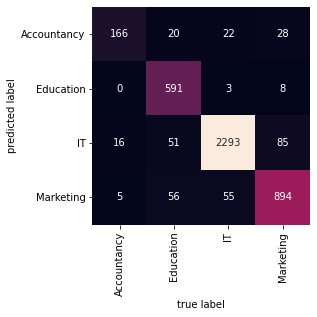

In [26]:
#On testing
classes = ['Accountancy','Education','IT','Marketing']
pred_y_test = MLP_clf.predict(X_test['job_title_clean'])
print(classification_report(y_test, pred_y_test))
mat = (confusion_matrix(y_test,pred_y_test)).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


In [15]:
# Saving the model
dump(MLP_clf,'MLPModel1.joblib')

['MLPModel1.joblib']

In [30]:
from sklearn.metrics import f1_score
print("F1 Score = ", f1_score(y_test, pred_y_test,average='macro'))

F1 Score =  0.8787836810738296


# SGD Classifier

In [37]:
clf_SGD_pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])
# using class weight balanced to handle imbalance
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), ],
    'tfidf__use_idf': (True, False),
    'clf__random_state': (0, ),
    'clf__alpha': (1e-2, 1e-3, 1e-4, 0.1, 1e-6, ),
    'clf__max_iter': (2, 5, 10, 20, 100, 200,500),
    'clf__class_weight': ['balanced'],
    'clf__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'clf__loss': ['hinge','perceptron','log']
}

sgd_clf_gscv = GridSearchCV(clf_SGD_pipeline, parameters, cv=5,  n_jobs=-1)

In [38]:
sgd_clf_gscv.fit(X_train['job_title_clean'],y_train)

C:\Users\trast\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.001, 0.0001, 0.1, 1e-06),
                         'clf__class_weight': ['balanced'],
                         'clf__loss': ['hinge', 'perceptron', 'log'],
                         'clf__max_iter': (2, 5, 10, 20, 100, 200, 500),
                         'clf__penalty': ['none', 'l2', 'l1', 'elasticnet'],
                         'clf__random_state': (0,),
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]})

In [39]:
model = sgd_clf_gscv.best_estimator_
pred_y_train_sgd = model.predict(X_train['job_title_clean'])
pred_y_val_sgd = model.predict(X_val['job_title_clean'])

print("On the Trainig data: ")
print(confusion_matrix(y_train, pred_y_train_sgd))
print(classification_report(y_train, pred_y_train_sgd))

print("\nOn validation data: ")
print(confusion_matrix(y_val, pred_y_val_sgd))
print(classification_report(y_val, pred_y_val_sgd))

On the Trainig data: 
[[115   0   1   0]
 [  4 406   4  20]
 [  3  16 791  25]
 [  7   6  17 505]]
              precision    recall  f1-score   support

 Accountancy       0.89      0.99      0.94       116
   Education       0.95      0.94      0.94       434
          IT       0.97      0.95      0.96       835
   Marketing       0.92      0.94      0.93       535

    accuracy                           0.95      1920
   macro avg       0.93      0.95      0.94      1920
weighted avg       0.95      0.95      0.95      1920


On validation data: 
[[ 21   2   2   4]
 [  0  96   4   9]
 [  0  13 182  14]
 [  3  13  11 106]]
              precision    recall  f1-score   support

 Accountancy       0.88      0.72      0.79        29
   Education       0.77      0.88      0.82       109
          IT       0.91      0.87      0.89       209
   Marketing       0.80      0.80      0.80       133

    accuracy                           0.84       480
   macro avg       0.84      0.82      0.

              precision    recall  f1-score   support

 Accountancy       0.79      0.84      0.81       187
   Education       0.85      0.88      0.86       718
          IT       0.97      0.92      0.94      2373
   Marketing       0.85      0.91      0.88      1015

    accuracy                           0.91      4293
   macro avg       0.86      0.89      0.87      4293
weighted avg       0.91      0.91      0.91      4293



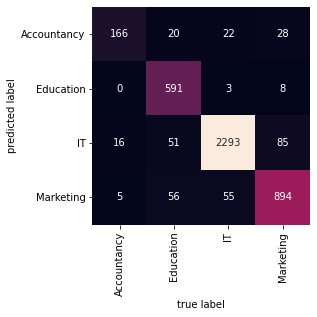

In [40]:
pred_y_test_sgd = model.predict(X_test['job_title_clean'])


print(classification_report(y_test, pred_y_test_sgd))
mat = (confusion_matrix(y_test,pred_y_test)).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [43]:
dump(model,'SGDModel1.joblib')

['SGDModel1.joblib']

In [42]:
sgd_clf_gscv.best_params_

{'clf__alpha': 0.0001,
 'clf__class_weight': 'balanced',
 'clf__loss': 'log',
 'clf__max_iter': 10,
 'clf__penalty': 'l2',
 'clf__random_state': 0,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 1)}

# Flask app
### uncomment this and run if you want to work from here not from the virtual environment

example: /?jobtitle='full stack developer, oxfordshire, Â£40k'

In [22]:
def cleaning_word(title):
    #Removing leading and tailing spaces
    title_cleaned = title.strip()
    title_cleaned = title_cleaned.split('-')
    title_cleaned = title_cleaned[0]
    # Making sure that all of the letters are lower
    title_cleaned = title_cleaned.lower()
    #Removing unuseful words
    words_to_remove = ['senior','junior','full','pre','mid','part','entry level','time','arabic','english'
                       ,'up','to','based',' and',' &',' in',' of']
    for word in words_to_remove:
        title_cleaned = title_cleaned.replace(word, '')
    #Keeping only words
    title_cleaned = re.sub(r"[^a-zA-Z ]","",title_cleaned)
    return title_cleaned

In [31]:
from werkzeug.wrappers import Request, Response
from flask import Flask
from flask import request
from werkzeug.serving import run_simple

app = Flask(__name__)

@app.route("/")
def hello():
    if (request.args.get('jobtitle')):
        job_title = request.args.get('jobtitle')
        jobtitle_cleaned = cleaning_word(job_title)
        return list(model.predict([jobtitle_cleaned]))[0]
    else:
        return "Hello! enter jobtitle parameter"


    
run_simple('localhost', 9000, app)

 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Sep/2021 13:24:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Sep/2021 13:24:06] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [20/Sep/2021 13:24:30] "GET /?jobtitle=%27sales%20engineer%27 HTTP/1.1" 200 -
127.0.0.1 - - [20/Sep/2021 13:24:40] "GET /?jobtitle=%27sales%20manager%27 HTTP/1.1" 200 -
